In [1]:
import torch
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm, trange
import time

In [2]:
root = "data"

train_data = dataset.MNIST(
    root=root,
    train=True,
    download=True,
)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f"Mean: {mean}")
print(f"Std: {std}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1602515.17it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 117478.13it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 761531.13it/s] 


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Mean: 0.13066047430038452
Std: 0.30810779333114624


In [3]:
train_transform = transforms.Compose(
    [
        transforms.RandomRotation(5, fill=(0,)),
        transforms.RandomCrop(28, padding=2, fill=(0,)),
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,)),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,)),
    ]
)


In [4]:
train_data = dataset.MNIST(
    root=root,
    train=True,
    transform=train_transform,
)
test_data = dataset.MNIST(
    root=root,
    train=False,
    transform=test_transform,
)

In [5]:
from copy import deepcopy
n_train_data = int(len(train_data) * 0.9)
n_val_data = int(len(train_data) - n_train_data)

train_data, val_data = torch.utils.data.random_split(train_data, [n_train_data, n_val_data])

val_data = deepcopy(val_data)
val_data.dataset.transform = test_transform

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [6]:
batch_size = 64

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

## **Define Model**

In [7]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels= 16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        h = x
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x, h


In [8]:
model = LeNet(10)

def count_parameter(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameter(model):,} trainable parameters')

The model has 44,426 trainable parameters


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
citerion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
citerion = citerion.to(device)

device

device(type='cuda')

In [10]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [12]:
def train(model, citerion, optimizer, train_loader, num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in tqdm(train_loader, desc="Training", leave = False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        acc = calculate_accuracy(y_pred, y)
        loss = citerion(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    return epoch_loss, epoch_acc

In [13]:
def evaluate(model, citerion, val_loader):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(val_loader, desc="Evaluating", leave = False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)
            acc = calculate_accuracy(y_pred, y)
            loss = citerion(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    epoch_loss /= len(val_loader)
    epoch_acc /= len(val_loader)
    return epoch_loss, epoch_acc


In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [15]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, citerion, optimizer, train_loader, EPOCHS)
    valid_loss, valid_acc = evaluate(model, citerion, val_loader)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'LeNet-Model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 0.387 | Train Acc: 87.79%
	 Val. Loss: 0.103 |  Val. Acc: 96.95%


Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.133 | Train Acc: 95.97%
	 Val. Loss: 0.102 |  Val. Acc: 96.69%


Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 0.098 | Train Acc: 96.94%
	 Val. Loss: 0.066 |  Val. Acc: 97.88%


Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.082 | Train Acc: 97.48%
	 Val. Loss: 0.063 |  Val. Acc: 98.03%


Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.072 | Train Acc: 97.72%
	 Val. Loss: 0.044 |  Val. Acc: 98.66%


Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.063 | Train Acc: 98.04%
	 Val. Loss: 0.046 |  Val. Acc: 98.68%


Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 0.060 | Train Acc: 98.12%
	 Val. Loss: 0.039 |  Val. Acc: 98.88%


Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 0.056 | Train Acc: 98.28%
	 Val. Loss: 0.046 |  Val. Acc: 98.68%


Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 0.051 | Train Acc: 98.36%
	 Val. Loss: 0.043 |  Val. Acc: 98.71%


Epoch: 10 | Epoch Time: 0m 13s
	Train Loss: 0.049 | Train Acc: 98.50%
	 Val. Loss: 0.037 |  Val. Acc: 98.96%


Epoch: 11 | Epoch Time: 0m 13s
	Train Loss: 0.048 | Train Acc: 98.45%
	 Val. Loss: 0.049 |  Val. Acc: 98.60%


Epoch: 12 | Epoch Time: 0m 13s
	Train Loss: 0.044 | Train Acc: 98.63%
	 Val. Loss: 0.036 |  Val. Acc: 98.88%


Epoch: 13 | Epoch Time: 0m 14s
	Train Loss: 0.041 | Train Acc: 98.67%
	 Val. Loss: 0.062 |  Val. Acc: 98.15%


Epoch: 14 | Epoch Time: 0m 13s
	Train Loss: 0.040 | Train Acc: 98.79%
	 Val. Loss: 0.036 |  Val. Acc: 98.91%


Epoch: 15 | Epoch Time: 0m 13s
	Train Loss: 0.041 | Train Acc: 98.76%
	 Val. Loss: 0.038 |  Val. Acc: 98.80%


Epoch: 16 | Epoch Time: 0m 13s
	Train Loss: 0.037 | Train Acc: 98.83%
	 Val. Loss: 0.035 |  Val. Acc: 99.06%


Epoch: 17 | Epoch Time: 0m 14s
	Train Loss: 0.036 | Train Acc: 98.89%
	 Val. Loss: 0.030 |  Val. Acc: 99.15%


Epoch: 18 | Epoch Time: 0m 14s
	Train Loss: 0.035 | Train Acc: 98.94%
	 Val. Loss: 0.033 |  Val. Acc: 99.08%


Epoch: 19 | Epoch Time: 0m 14s
	Train Loss: 0.032 | Train Acc: 99.01%
	 Val. Loss: 0.032 |  Val. Acc: 99.06%


Epoch: 20 | Epoch Time: 0m 14s
	Train Loss: 0.033 | Train Acc: 99.03%
	 Val. Loss: 0.033 |  Val. Acc: 98.95%


In [18]:
model.load_state_dict(torch.load('LeNet-Model.pt'))

test_loss, test_acc = evaluate(model, citerion, test_loader)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

C:\Users\hieuh\AppData\Local\Temp\ipykernel_16956\1654476365.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('LeNet-Model.pt'))
        

Test Loss: 0.026 | Test Acc: 99.15%


In [20]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [23]:
images, labels, probs = get_predictions(model, test_loader)
pred_labels = torch.argmax(probs, 1)
len(pred_labels)

10000

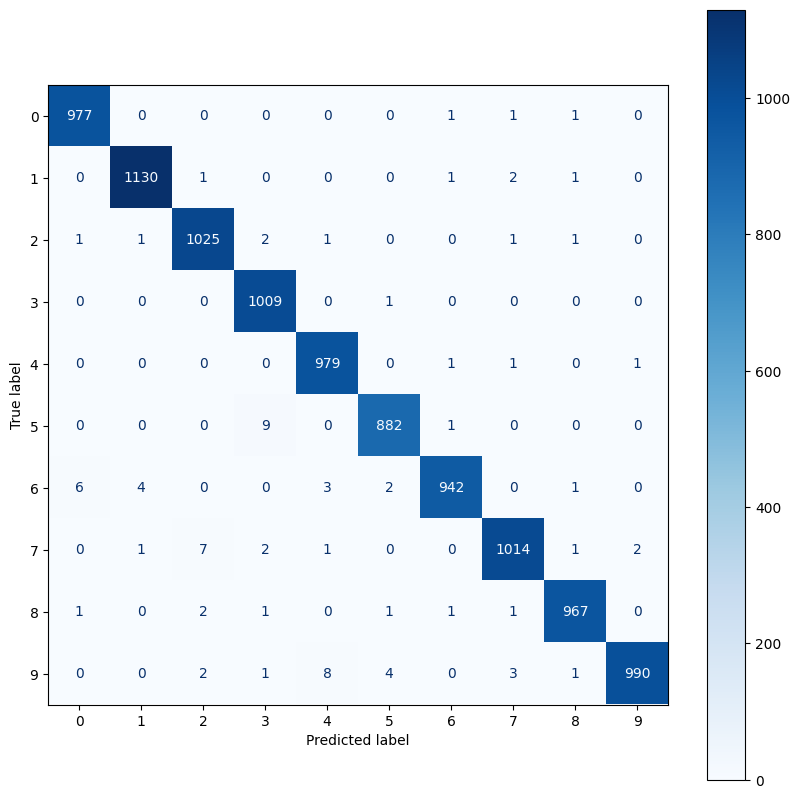

In [24]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

plot_confusion_matrix(labels, pred_labels)